# Load Data

In [40]:
import pandas as pd

# Baca file hasil scraping
df = pd.read_csv("C:/Users/Thinkpad T460s/Downloads/deeplern tubes/Scrapping komen tiktok - dataset_tiktok-comments-scraper - Scrapping komen tiktok - dataset_tiktok-comments-scraper.csv.csv", sep=',', quotechar='"', engine='python', on_bad_lines='skip')

# Cek struktur data
print(df.shape)
print(df[['text']].head())

(36022, 11)
                        text
0  hey heyy look at me✋️✋️✋️
1             ilang arah yaa
2         day 1 hilang arah😊
3             👁️: sori gugup
4   lgian nantang bgt anj😭😭😭


# Pra-processing

In [41]:
# cek data duplikat
print(df.duplicated(subset=['text']).sum())

4426


In [14]:
# cek data kosong
print(df.isna().sum())

text                   440
diggCount               13
replyCommentTotal       13
createTimeISO           22
uniqueId                22
videoWebUrl             22
uid                     22
cid                     22
Label                    0
Unnamed: 9           36018
Unnamed: 10          36020
dtype: int64


In [42]:
# hapus data duplikat dan komentar kosong
df = df.drop_duplicates(subset=['text'])
df = df.dropna(subset=['text'])

In [43]:
# Hitung Panjang Komentar
df['char_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

print(df[['char_len', 'word_count']].describe())

           char_len    word_count
count  31595.000000  31595.000000
mean      43.487640      7.493433
std       59.135048      9.874857
min        1.000000      1.000000
25%       19.000000      3.000000
50%       31.000000      5.000000
75%       50.000000      9.000000
max     2177.000000    765.000000


In [44]:
import re
import string

# Case Folding + Text Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # hapus URL
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # hapus mention
    text = re.sub(r'#\S+', '', text)           # hapus hashtag
    text = re.sub(r'[^a-z\s]', '', text)       # hapus non-huruf
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].astype(str).apply(clean_text)  # timpa langsung kolom 'text' biar bersih

In [45]:
# Remove Stopward
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

df['no_stopword'] = df['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to C:\Users\Thinkpad
[nltk_data]     T460s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Tokenization
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

df['tokens_nltk'] = df['no_stopword'].apply(word_tokenize)

[nltk_data] Downloading package punkt to C:\Users\Thinkpad
[nltk_data]     T460s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Thinkpad
[nltk_data]     T460s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data]   Package punkt_tab is already up-to-date!


# Balancing Data

In [47]:
# BALANCING DATA (UNDERSAMPLING + OVERSAMPLING)

from sklearn.utils import resample

df_majority = df[df['Label'] == 0]
df_minority = df[df['Label'] == 1]

print("Sebelum balancing:")
print(df['Label'].value_counts())

# 1. Undersampling ringan kelas 0 → turunkan ke 15000
df_majority_under = resample(df_majority, replace=False, n_samples=15000, random_state=42)

# 2. Oversampling ringan kelas 1 → naikkan ke 6000
df_minority_over  = resample(df_minority, replace=True, n_samples=6000, random_state=42)

# Gabungkan
df_balanced = pd.concat([df_majority_under, df_minority_over]).sample(frac=1, random_state=42)
df_balanced = df_balanced.reset_index(drop=True)

print("\nSetelah balancing:")
print(df_balanced['Label'].value_counts())

Sebelum balancing:
Label
0    28612
1     2983
Name: count, dtype: int64

Setelah balancing:
Label
0    15000
1     6000
Name: count, dtype: int64

Setelah balancing:
Label
0    15000
1     6000
Name: count, dtype: int64


# Desain dan Implementasi Awal Model

### **Inisiasi Model LSTM**

Model LSTM diinisialisasi untuk mendeteksi komentar *cyberbullying* berdasarkan urutan kata. Model diawali dengan *embedding layer* berdimensi (100,100). Selanjutnya digunakan satu *LSTM layer* berukuran 128 unit, diikuti *dropout layer* dengan nilai 0,2 untuk mencegah *overfitting*. Hasil keluaran diteruskan ke *dense layer* dengan aktivasi sigmoid untuk klasifikasi biner. Model menggunakan *optimizer* yang di hyperparameter dengan *learning rate* 0,001 dan *loss function* binary cross-entropy.


In [48]:
# IMPLEMENTASI AWAL MODEL CNN-LSTM

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# reset index supaya resampling tidak bikin index duplikat / aneh
df_balanced = df_balanced.reset_index(drop=True)

# Definisikan variabel input & label dari data yang sudah dibalance
texts = df_balanced['no_stopword'].astype(str).tolist()
labels = df_balanced['Label'].astype(int).tolist()

# 1. Tokenisasi teks -> ubah kata jadi angka
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 2. Padding -> samakan panjang setiap urutan (biar bisa masuk ke CNN-LSTM)
maxlen = 300  # panjang maksimal per teks
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = np.array(labels)

# 3. Split data jadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vocab_size = len(tokenizer.word_index) + 1

print("\nJumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])
print("Panjang sequence:", X_train.shape[1])
print("Jumlah kata unik:", len(tokenizer.word_index))

print("\nDistribusi Label (sebelum split):")
print(pd.Series(y).value_counts())

print("\nDistribusi Label (train):")
print(pd.Series(y_train).value_counts())

print("\nDistribusi Label (test):")
print(pd.Series(y_test).value_counts())


Jumlah data latih: 16800
Jumlah data uji: 4200
Panjang sequence: 300
Jumlah kata unik: 17934

Distribusi Label (sebelum split):
0    15000
1     6000
Name: count, dtype: int64

Distribusi Label (train):
0    12000
1     4800
Name: count, dtype: int64

Distribusi Label (test):
0    3000
1    1200
Name: count, dtype: int64


In [49]:
# INISIALISASI MODEL CNN-BiLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense

# Parameter dasar
vocab_size = len(tokenizer.word_index) + 1   # jumlah kata unik dari tokenizer
embedding_dim = 100                          # dimensi embedding
max_len = 300                                # panjang maksimal sequence

# Bangun model CNN-BiLSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len),

    # CNN untuk ekstraksi fitur lokal
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Bidirectional LSTM untuk menangkap konteks dua arah
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),

    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

# Build agar summary lengkap
model.build(input_shape=(None, max_len))

# Tampilkan arsitektur
model.summary()

c:\Users\Thinkpad T460s\Downloads\deeplern tubes\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 100)       │     1,793,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 148, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,964,765 (7.49 MB)

 Trainable params: 1,964,765 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

# Training dan Tuning

## Import library dan setup dasar

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import itertools
import os

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.makedirs("models", exist_ok=True)

## Build Model LSTM

In [51]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense

def build_lstm_model(vocab_size, max_len, optimizer="adam"):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=100,
                  input_length=max_len),

        # 1️⃣ Convolution untuk ekstraksi fitur n-gram
        Conv1D(filters=128, kernel_size=5, activation="relu"),
        MaxPooling1D(pool_size=2),

        # 2️⃣ Bidirectional LSTM untuk konteks depan–belakang
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),

        # 3️⃣ Dense layer
        Dense(64, activation="relu"),
        Dropout(0.3),

        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    return model

## Hyperparameter Grid (Optimizer + Epochs)

In [52]:
param_optimizer = ["adam", "rmsprop"]
param_epochs = [5, 10]

# Buat kombinasi
grid_combinations = list(itertools.product(param_optimizer, param_epochs))
print("Total combinations:", len(grid_combinations))
grid_combinations

Total combinations: 4


[('adam', 5), ('adam', 10), ('rmsprop', 5), ('rmsprop', 10)]

In [31]:
import time

best_model = None
best_history = None
best_val_loss = np.inf

start_time = time.time()

for (opt, ep) in grid_combinations:
    print(f"\n=== Training {opt}, epochs={ep} ===")

    tf.keras.backend.clear_session()

    model_i = build_lstm_model(vocab_size, 300, optimizer=opt)
    history = model_i.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=ep,
        batch_size=64,
        verbose=2
    )

    min_val = min(history.history['val_loss'])
    print("min val loss =", min_val)

    if min_val < best_val_loss:
        best_val_loss = min_val
        best_model = model_i
        best_history = history  # <--- Added this line to store the best history
        model_i.save("models/best_lstm_final.h5")
        print(" ✓ Improved! Model saved.")


=== Training adam, epochs=5 ===



c:\Users\Thinkpad T460s\Downloads\deeplern tubes\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
237/237 - 110s - 462ms/step - accuracy: 0.7456 - auc: 0.6662 - loss: 0.5491 - val_accuracy: 0.7845 - val_auc: 0.7949 - val_loss: 0.4779
Epoch 2/5
237/237 - 87s - 367ms/step - accuracy: 0.8769 - auc: 0.9170 - loss: 0.3122 - val_accuracy: 0.8292 - val_auc: 0.8561 - val_loss: 0.4359
Epoch 3/5
237/237 - 85s - 359ms/step - accuracy: 0.9422 - auc: 0.9787 - loss: 0.1593 - val_accuracy: 0.8589 - val_auc: 0.8730 - val_loss: 0.4848
Epoch 4/5
237/237 - 87s - 365ms/step - accuracy: 0.9626 - auc: 0.9916 - loss: 0.1013 - val_accuracy: 0.8506 - val_auc: 0.8651 - val_loss: 0.6284
Epoch 5/5
237/237 - 87s - 365ms/step - accuracy: 0.9722 - auc: 0.9945 - loss: 0.0797 - val_accuracy: 0.8536 - val_auc: 0.8658 - val_loss: 0.6920


min val loss = 0.43591147661209106
 ✓ Improved! Model saved.

=== Training adam, epochs=10 ===
Epoch 1/10
237/237 - 116s - 491ms/step - accuracy: 0.7503 - auc: 0.6888 - loss: 0.5390 - val_accuracy: 0.7887 - val_auc: 0.8046 - val_loss: 0.4675
Epoch 2/10
237/237 - 85s - 360ms/step - accuracy: 0.8810 - auc: 0.9272 - loss: 0.2955 - val_accuracy: 0.8321 - val_auc: 0.8640 - val_loss: 0.4293
Epoch 3/10
237/237 - 85s - 359ms/step - accuracy: 0.9457 - auc: 0.9816 - loss: 0.1489 - val_accuracy: 0.8393 - val_auc: 0.8724 - val_loss: 0.5142
Epoch 4/10
237/237 - 85s - 357ms/step - accuracy: 0.9648 - auc: 0.9923 - loss: 0.0972 - val_accuracy: 0.8506 - val_auc: 0.8723 - val_loss: 0.5980
Epoch 5/10
237/237 - 85s - 358ms/step - accuracy: 0.9733 - auc: 0.9946 - loss: 0.0787 - val_accuracy: 0.8625 - val_auc: 0.8735 - val_loss: 0.6059
Epoch 6/10
237/237 - 84s - 355ms/step - accuracy: 0.9733 - auc: 0.9955 - loss: 0.0719 - val_accuracy: 0.8560 - val_auc: 0.8728 - val_loss: 0.6399
Epoch 7/10
237/237 - 145s - 

min val loss = 0.4292948544025421
 ✓ Improved! Model saved.

=== Training rmsprop, epochs=5 ===
Epoch 1/5
237/237 - 102s - 429ms/step - accuracy: 0.7154 - auc: 0.4981 - loss: 0.6026 - val_accuracy: 0.7036 - val_auc: 0.5812 - val_loss: 0.6105
Epoch 2/5
237/237 - 85s - 359ms/step - accuracy: 0.7378 - auc: 0.6671 - loss: 0.5556 - val_accuracy: 0.7292 - val_auc: 0.7609 - val_loss: 0.5375
Epoch 3/5
237/237 - 145s - 610ms/step - accuracy: 0.8234 - auc: 0.8467 - loss: 0.4173 - val_accuracy: 0.7411 - val_auc: 0.8104 - val_loss: 0.5191
Epoch 4/5
237/237 - 85s - 359ms/step - accuracy: 0.8819 - auc: 0.9181 - loss: 0.3095 - val_accuracy: 0.7595 - val_auc: 0.8355 - val_loss: 0.5239
Epoch 5/5
237/237 - 89s - 374ms/step - accuracy: 0.9210 - auc: 0.9596 - loss: 0.2187 - val_accuracy: 0.7077 - val_auc: 0.8574 - val_loss: 0.6550
min val loss = 0.5190972685813904

=== Training rmsprop, epochs=10 ===
Epoch 1/10
237/237 - 103s - 436ms/step - accuracy: 0.7144 - auc: 0.5011 - loss: 0.6026 - val_accuracy: 0.7

## Evaluasi Model Terbaik

In [32]:
y_prob = best_model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step
Accuracy: 0.8376190476190476
ROC AUC: 0.8861345833333333

Classification report:
               precision    recall  f1-score   support

           0     0.9211    0.8450    0.8814      3000
           1     0.6789    0.8192    0.7424      1200

    accuracy                         0.8376      4200
   macro avg     0.8000    0.8321    0.8119      4200
weighted avg     0.8519    0.8376    0.8417      4200

[[2535  465]
 [ 217  983]]


## Plot ROC Curve

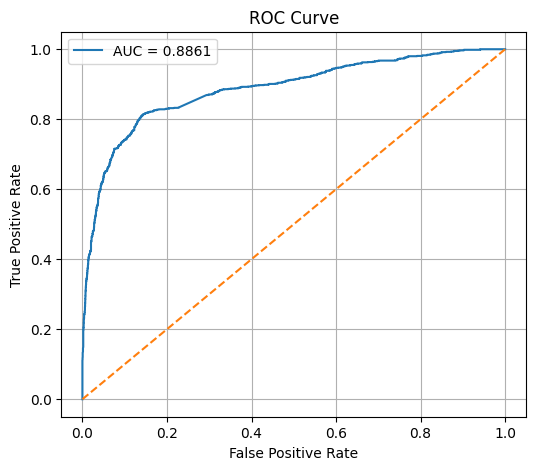

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## Plot History dari Model Terbaik

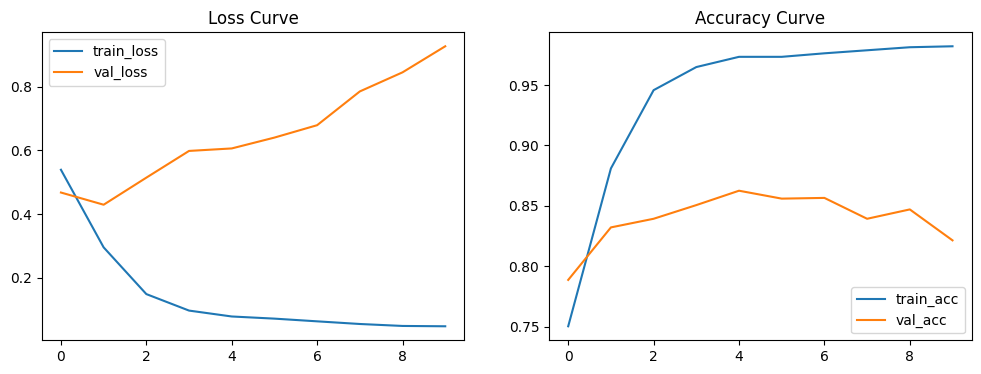

In [34]:
h = best_history.history

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(h['accuracy'], label='train_acc')
plt.plot(h['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [61]:
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, precision_recall_curve,
)
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Config
USE_CLASS_WEIGHT = True
USE_OVERSAMPLING = True           # perbanyak bully
USE_FOCAL_LOSS = True            # set True jika mau
USE_F1_THRESHOLD = True           # threshold otomatis F1
FIXED_THRESHOLD = 0.4             # dipakai jika USE_F1_THRESHOLD=False
EPOCHS = 20
BATCH_SIZE = 64
MODEL_OUT = "models/best_lstm_final_balanced.h5"

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = -alpha_factor * modulating_factor * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return focal_loss

# Oversampling bully (auto-skip jika imblearn belum ada)
X_train_res, y_train_res = X_train, y_train
if USE_OVERSAMPLING:
    try:
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
        print("After oversampling class counts:", np.bincount(y_train_res))
    except Exception as e:
        print("Oversampling dilewati (imblearn tidak tersedia/error):", e)

# Class weights
cw = None
if USE_CLASS_WEIGHT:
    classes = np.unique(y_train_res)
    cw_vals = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train_res)
    cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
    print("Using class weights:", cw)

# Build & compile
tf.keras.backend.clear_session()
model_bal = build_lstm_model(vocab_size=vocab_size, max_len=300, optimizer="adam")
loss_fn = binary_focal_loss(gamma=2.0, alpha=0.25) if USE_FOCAL_LOSS else "binary_crossentropy"
model_bal.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

callbacks = [
    ModelCheckpoint(MODEL_OUT, monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
]

# Train
history_bal = model_bal.fit(
    X_train_res, y_train_res,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=cw if cw is not None else None,
    callbacks=callbacks,
    verbose=2,
)

# Evaluate
y_prob_bal = model_bal.predict(X_test).ravel()
y_pred_bal_default = (y_prob_bal >= 0.5).astype(int)
print("Default threshold 0.5 report:\n", classification_report(y_test, y_pred_bal_default, digits=4))

best_thr = FIXED_THRESHOLD
if USE_F1_THRESHOLD:
    prec, rec, thr = precision_recall_curve(y_test, y_prob_bal)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    best_idx = int(np.argmax(f1))
    if best_idx < len(thr):
        best_thr = float(thr[best_idx])
    print("Best F1 threshold:", best_thr, "F1:", f1[best_idx])

y_pred_bal = (y_prob_bal >= best_thr).astype(int)
print("Tuned threshold report:\n", classification_report(y_test, y_pred_bal, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("ROC AUC:", roc_auc_score(y_test, y_prob_bal))
print("Best balanced model saved to", MODEL_OUT)


Oversampling dilewati (imblearn tidak tersedia/error): No module named 'imblearn'
Using class weights: {0: 0.7, 1: 1.75}


c:\Users\Thinkpad T460s\Downloads\deeplern tubes\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20

Epoch 1: val_loss improved from None to 0.04809, saving model to models/best_lstm_final_balanced.h5

Epoch 1: val_loss improved from None to 0.04809, saving model to models/best_lstm_final_balanced.h5


237/237 - 80s - 338ms/step - accuracy: 0.7349 - auc: 0.6682 - loss: 0.0550 - val_accuracy: 0.7690 - val_auc: 0.8008 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 2/20
Epoch 2/20

Epoch 2: val_loss improved from 0.04809 to 0.04733, saving model to models/best_lstm_final_balanced.h5

Epoch 2: val_loss improved from 0.04809 to 0.04733, saving model to models/best_lstm_final_balanced.h5


237/237 - 74s - 311ms/step - accuracy: 0.8617 - auc: 0.9248 - loss: 0.0314 - val_accuracy: 0.8429 - val_auc: 0.8696 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 3/20
Epoch 3/20

Epoch 3: val_loss did not improve from 0.04733
237/237 - 74s - 311ms/step - accuracy: 0.9413 - auc: 0.9837 - loss: 0.0153 - val_accuracy: 0.8625 - val_auc: 0.8698 - val_loss: 0.0698 - learning_rate: 0.0010
Epoch 4/20

Epoch 3: val_loss did not improve from 0.04733
237/237 - 74s - 311ms/step - accuracy: 0.9413 - auc: 0.9837 - loss: 0.0153 - val_accuracy: 0.8625 - val_auc: 0.8698 - val_loss: 0.0698 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_loss did not improve from 0.04733
237/237 - 73s - 309ms/step - accuracy: 0.9622 - auc: 0.9928 - loss: 0.0101 - val_accuracy: 0.8613 - val_auc: 0.8688 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 5/20

Epoch 4: val_loss did not improve from 0.04733
237/237 - 73s - 309ms/step - accuracy: 0.9622 - auc: 0.9928 - loss: 0.0101 - val_accuracy: 0.8613 - val_auc: 0.8688 -

In [75]:
from pathlib import Path
import shutil

base = Path(".")
model_dir = base / "models"
export_dir = base / "exports"
export_dir.mkdir(exist_ok=True)

# 1) Ambil model terbaru (mtime paling baru)
model_files = sorted(model_dir.glob("*.h5"), key=lambda p: p.stat().st_mtime, reverse=True)
if not model_files:
    raise FileNotFoundError("Tidak ada file .h5 di folder models/")
latest_model = model_files[0]
model_mtime = latest_model.stat().st_mtime

# 2) Cari tokenizer (prefer yang waktunya <= model terbaru, jika ada)
tokenizers = sorted(base.rglob("tokenizer*.pickle"), key=lambda p: p.stat().st_mtime, reverse=True)
if not tokenizers:
    raise FileNotFoundError("Tidak ada tokenizer*.pickle ditemukan.")
chosen_tokenizer = next((t for t in tokenizers if t.stat().st_mtime <= model_mtime), tokenizers[0])

# 3) Salin ke exports dengan nama yang jelas
dest = export_dir / f"tokenizer_for_{latest_model.stem}.pickle"
shutil.copy2(chosen_tokenizer, dest)

print(f"Model terbaru : {latest_model}")
print(f"Tokenizer dipakai: {chosen_tokenizer}")
print(f"Salinan siap diambil di: {dest.resolve()}")


Model terbaru : models\model_terbaik.h5
Tokenizer dipakai: tokenizer.pickle
Salinan siap diambil di: C:\Users\Thinkpad T460s\Downloads\deeplern tubes\exports\tokenizer_for_model_terbaik.pickle


In [71]:
model_bal.save("models/model_terbaik.h5")
print("Model terbaik telah disimpan sebagai models/model_terbaik.h5")


Model terbaik telah disimpan sebagai models/model_terbaik.h5


In [70]:
from tensorflow.keras.models import load_model

# Fungsi sederhana untuk menerima input kalimat dan memprediksi bully / not bully
# Menggunakan pipeline preprocessing yang sudah ada: clean_text, stop_words, tokenizer, pad_sequences
# Menggunakan model terbaik yang ada di memori (best_model) atau model_bal atau mencoba load dari MODEL_OUT


def predict_bully_sentence(text, model=None, tokenizer=tokenizer, maxlen=300, threshold=None):
    """
    Input: text (str)
    Output: tuple (label_str, prob_float)
    """
    # pilih model: parameter > best_model > model_bal > coba load dari disk
    if model is None:
        model = globals().get('best_model') or globals().get('model_bal')
        if model is None:
            try:
                model = load_model(globals().get('MODEL_OUT', 'models/best_lstm_final_balanced.h5'))
            except Exception:
                try:
                    model = load_model('models/best_lstm_final.h5')
                except Exception as e:
                    raise RuntimeError("Tidak menemukan model di memori atau file. Pastikan best_model/model_bal atau file .h5 tersedia.") from e

    # ambil threshold terbaik jika tersedia, fallback ke 0.5
    thr = threshold if threshold is not None else globals().get('best_thr', 0.5)

    # preprocessing sesuai pipeline notebook
    txt_clean = clean_text(text)
    txt_no_stop = ' '.join([w for w in txt_clean.split() if w not in stop_words])

    seq = tokenizer.texts_to_sequences([txt_no_stop])
    X = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

    prob = float(model.predict(X).ravel()[0])
    label = "BULLY" if prob >= thr else "NOT BULLY"

    return label, prob

# Interactive usage in a notebook cell
inp = input("Masukkan kalimat untuk dicek (enter untuk batal): ").strip()
if inp:
    label, prob = predict_bully_sentence(inp)
    print(f"Prediksi: {label}  (probabilitas = {prob:.4f}, threshold = {globals().get('best_thr', 0.5)})")
else:
    print("Dibatalkan.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediksi: BULLY  (probabilitas = 0.5336, threshold = 0.46755287051200867)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediksi: BULLY  (probabilitas = 0.5336, threshold = 0.46755287051200867)


In [77]:
# Load tokenizer
import pickle
with open('exports/tokenizer_for_model_terbaik.pickle', 'rb') as f:
    tok = pickle.load(f)

# Cek kata
print("bodoh" in tok.word_index)  # Harus True
print("tolol" in tok.word_index)   # Harus True
print("goblok" in tok.word_index)  # Harus True

True
True
True
